In [372]:
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from sklearn import tree
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gayathrisjs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gayathrisjs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**TDIDF matrix generation**

In [373]:

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def get_tokens(text):
    # turn document into lowercase
    lowers = text.lower()
    # remove punctuation
    no_punctuation = lowers.translate(remove_punctuation_map)
    # tokenize document
    tokens = nltk.word_tokenize(no_punctuation)
    # stop words
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    # stemming process
    stemmed = []
    for item in filtered:
        stemmed.append(stemmer.stem(item))

    return stemmed


In [374]:

def get_dict(fpath):
    dictionary = {}


    with open(fpath, "r") as f:
        for i, word in enumerate(f):
            dictionary[word.strip()] = i

    return dictionary


def get_doc_tf(word_set, dictionary):
    n_words = len(dictionary)
    tf_vec = np.zeros(n_words)

    max_cnt = 0
    for word in word_set:
        idx = dictionary[word]
        tf_vec[idx] += 1.0

        if tf_vec[idx] > max_cnt:
            max_cnt = tf_vec[idx]

    return tf_vec / max_cnt



def get_tf_idf(tf_dict, df_vec, n_doc, n_words):

    tf_idf_mtx = np.zeros((n_doc, n_words))
    idf = np.log(n_doc / df_vec)

    for doc_idx, tf_vec in tf_dict.items():
        tf_idf = tf_dict[doc_idx]*idf

        tf_idf_mtx[doc_idx, :] = tf_idf

    return tf_idf_mtx




In [375]:
def tfidf_main(fpath, dictionary, test):


    n_words = len(dictionary)
    tf = {}
    doc_freq = np.zeros(n_words)

    with open(fpath, 'r') as f:

        lines = f.readlines()
        n_doc = len(lines) - 1

        for i, line in tqdm(enumerate(lines), total=n_doc+1):
            if i == 0:
                continue

            doc_idx = i - 1

            if test:
                id, txt = line.split(",")
            else:
                id, txt, cat = line.split(",")
                cat = cat.strip()
            tokens = get_tokens(txt)

            filtered = []
            filtered_unique = set()
            for word in tokens:
                if word in dictionary:
                    filtered.append(word)
                    filtered_unique.add(word)

            # get term frequency
            tf_vec = get_doc_tf(filtered, dictionary)
            tf[doc_idx] = tf_vec

            # get doc frequency:
            for word in filtered_unique:
                idx = dictionary[word]
                doc_freq[idx] += 1


    tfidf_mtx = get_tf_idf(tf, doc_freq, n_doc, n_words)


    return tfidf_mtx

In [376]:
dictionary = get_dict("dictionary.txt")
tfidf = tfidf_main("24_train_1.csv", dictionary, False)


100%|███████████████████████████████████████| 1001/1001 [00:14<00:00, 71.13it/s]


In [377]:
data = pd.read_csv('24_train_1.csv')
Y = data['Category']
X = tfidf
X_train_TFIDF, X_val_TFIDF, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=50)

**Calculating training and validation accuracies for gini and entrophy criterions**

In [378]:
#Model training
clf_ent = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf_ent = clf_ent.fit(X_train_TFIDF, Y_train)

In [379]:
#Calculating training and validation accuracies for gini and entrophy criterions
criterion_values = ["gini", "entropy"]

gini_accuracies = []
entrophy_accuracies = []

for criterion in criterion_values:
    model = DecisionTreeClassifier(criterion=criterion, random_state=42)
    model.fit(X_train_TFIDF, Y_train)
    train_accuracy = model.score(X_train_TFIDF, Y_train)
    val_accuracy = model.score(X_val_TFIDF, Y_val)
    
    if criterion=='gini':
        gini_accuracies.append(train_accuracy)
        gini_accuracies.append(val_accuracy)
        
    else:
        entrophy_accuracies.append(train_accuracy)
        entrophy_accuracies.append(val_accuracy)
        


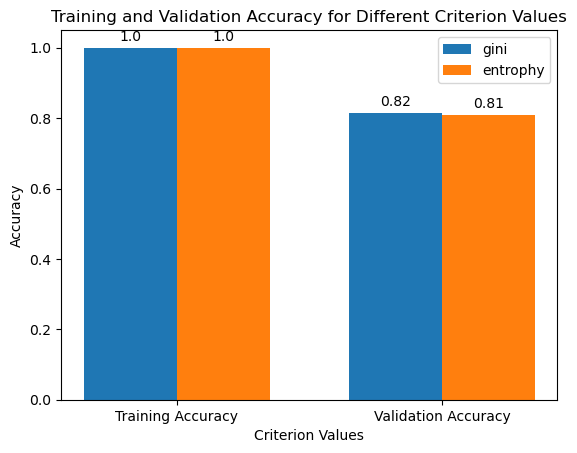

In [380]:
#plotting training and validation accuracies
criterion_values = ["Training Accuracy", "Validation Accuracy"]
bar_width = 0.35
index = np.arange(len(criterion_values))
a1=plt.bar(index, gini_accuracies, bar_width, label='gini')
a2=plt.bar(index + bar_width, entrophy_accuracies, bar_width, label='entrophy')
plt.xlabel('Criterion Values')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Different Criterion Values')
plt.xticks(index + bar_width / 2, criterion_values)
plt.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(a1)
autolabel(a2)
plt.show()

**Function to implement k-Fold validation for different Decision Tree models with varying min_samples_leaf values**

In [381]:
def dtc_parameter_tune(train_val_X, train_val_y):
    minsamples = [x for x in range(0,201,10)]
    minsamples[0]=1
    train_acc_all = []
    val_acc_all = []
    lis = []
    kf = KFold(n_splits = 5,shuffle= True, random_state=42)
    for minsample in minsamples:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = tree.DecisionTreeClassifier(min_samples_leaf=minsample, random_state=40)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        avg_std_train = np.std(train_acc)
        avg_std_val = np.std(val_acc)
        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        lis.append([minsample,avg_train_acc,avg_std_train,avg_val_acc,avg_std_val])

    return lis, minsamples, train_acc_all, val_acc_all

lis, minsamples, train_acc_all, val_acc_all = dtc_parameter_tune(X, Y)
cols = ['min_sample_leaf', 'Avg Training Accuracy', 'Std for Train Accuracy', 'Avg Validation Accuracy', 'Std for Validation Accuracy']
min_leaf_df = pd.DataFrame(lis, columns = cols)
min_leaf_df
# plot training/validation curves


,min_sample_leaf,Avg Training Accuracy,Std for Train Accuracy,Avg Validation Accuracy,Std for Validation Accuracy
0,1,1.00000,0.000000,0.802,0.013638
1,10,0.86300,0.009830,0.765,0.017607
2,20,0.79625,0.008023,0.704,0.036797
3,30,0.76350,0.016628,0.710,0.036469
4,40,0.73500,0.017695,0.690,0.043932
5,50,0.71525,0.012952,0.660,0.045277
6,60,0.70450,0.018466,0.664,0.046195
7,70,0.67500,0.011402,0.638,0.039319
8,80,0.64450,0.006354,0.608,0.051633
9,90,0.60800,0.011927,0.573,0.023791


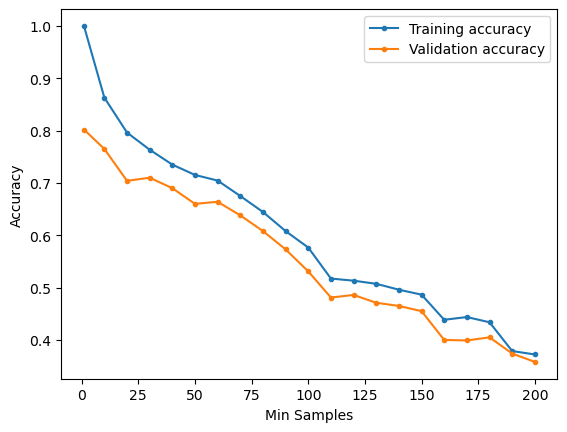

In [382]:
#plotting training and validation accuracies
plt.plot(minsamples, train_acc_all, marker='.', label="Training accuracy")
plt.plot(minsamples, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Min Samples')
plt.ylabel('Accuracy')
plt.legend()

**Function to implement k-Fold validation for different Decision Tree models with varying max_features values**

In [383]:
def dtc_parameter_tune_max_decision_tree(train_val_X, train_val_y):
    maxdepths = [x for x in range(0,401,10)]
    maxdepths[0]=1
    train_acc_all = []
    val_acc_all = []
    lis = []
    kf = KFold(n_splits = 5,shuffle= True, random_state=42)
    for maxdepth in maxdepths:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = tree.DecisionTreeClassifier(max_features = maxdepth, random_state=42)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        avg_std_train = np.std(train_acc)
        avg_std_val = np.std(val_acc)
        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        lis.append([maxdepth,avg_train_acc,avg_std_train,avg_val_acc,avg_std_val])

    return lis, maxdepths, train_acc_all, val_acc_all

lis, maxdepths, train_acc_all, val_acc_all = dtc_parameter_tune_max_decision_tree(X, Y)
cols = ['MaxFeature', 'Avg Training Accuracy', 'Std for Train Accuracy', 'Avg Validation Accuracy', 'Std for Validation Accuracy']
maxdepths_df = pd.DataFrame(lis, columns = cols)
maxdepths_df


,MaxFeature,Avg Training Accuracy,Std for Train Accuracy,Avg Validation Accuracy,Std for Validation Accuracy
0,1,1.0,0.0,0.451,0.051127
1,10,1.0,0.0,0.627,0.020881
2,20,1.0,0.0,0.731,0.032156
3,30,1.0,0.0,0.737,0.036959
4,40,1.0,0.0,0.727,0.026000
5,50,1.0,0.0,0.746,0.033377
6,60,1.0,0.0,0.767,0.027313
7,70,1.0,0.0,0.776,0.027092
8,80,1.0,0.0,0.762,0.018601
9,90,1.0,0.0,0.769,0.021307


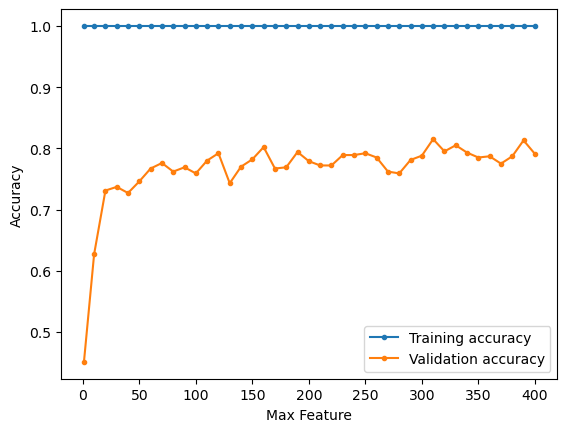

In [384]:
#plotting training and validation accuracies
plt.plot(maxdepths, train_acc_all, marker='.', label="Training accuracy")
plt.plot(maxdepths, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Max Feature')
plt.ylabel('Accuracy')
plt.legend()

**RANDOM FOREST CLASSIFIER**

The parameter settings for random forest classfier are 
- criterion : gini (default)
- max_depth : None (default)
- min_samples_split : 2 (default)




**Function to implement k-Fold validation for different Random Forest models with varying n_estimators values**

In [385]:
def dtc_parameter_tune_max_Random_Forest_tree(train_val_X, train_val_y):
    Trees = [x for x in range(0,101,10)]
    Trees[0]=1
    train_acc_all = []
    val_acc_all = []
    lis = []
    kf = KFold(n_splits = 5,shuffle= True, random_state=42)
    for tree in Trees:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = RandomForestClassifier(n_estimators = tree, random_state=42)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        avg_std_train = np.std(train_acc)
        avg_std_val = np.std(val_acc)
        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        lis.append([tree,avg_train_acc,avg_std_train,avg_val_acc,avg_std_val])

    return lis, Trees, train_acc_all, val_acc_all

lis, Trees, train_acc_all, val_acc_all = dtc_parameter_tune_max_Random_Forest_tree(X, Y)
cols = ['n_estimators', 'Avg Training Accuracy', 'Std for Train Accuracy', 'Avg Validation Accuracy', 'Std for Validation Accuracy']
n_estimators_df = pd.DataFrame(lis, columns = cols)
n_estimators_df

,n_estimators,Avg Training Accuracy,Std for Train Accuracy,Avg Validation Accuracy,Std for Validation Accuracy
0,1,0.88625,0.011859,0.673,0.041905
1,10,0.99875,0.001118,0.894,0.027092
2,20,0.99975,0.000500,0.919,0.016248
3,30,1.00000,0.000000,0.932,0.017493
4,40,1.00000,0.000000,0.942,0.013638
5,50,1.00000,0.000000,0.943,0.008718
6,60,1.00000,0.000000,0.946,0.009165
7,70,1.00000,0.000000,0.948,0.009274
8,80,1.00000,0.000000,0.952,0.008124
9,90,1.00000,0.000000,0.953,0.010296


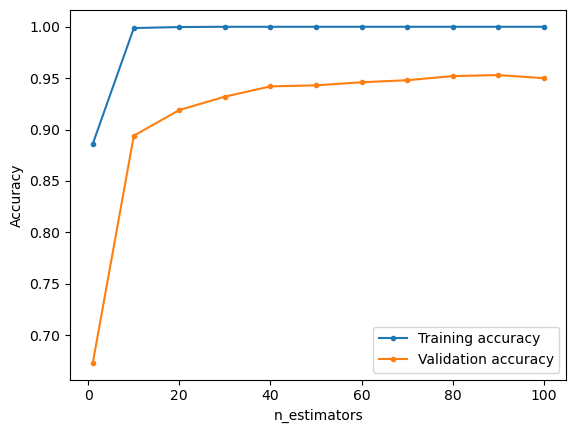

In [386]:
#plotting training and validation accuracies
plt.plot(Trees, train_acc_all, marker='.', label="Training accuracy")
plt.plot(Trees, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()

**Function to implement k-Fold validation for different Random Forest models with varying min_samples_leaf values**

In [387]:
def dtc_parameter_tune_RandomForestClassifier(train_val_X, train_val_y):
    minsamples = [x for x in range(0,201,10)]
    minsamples[0]=1
    train_acc_all = []
    val_acc_all = []
    lis = []
    kf = KFold(n_splits = 5,shuffle= True, random_state=42)
    for minsample in minsamples:
        train_acc = []
        val_acc = []
        for train_index, val_index in kf.split(train_val_X):
            ##########################
            train_X = train_val_X[train_index,:]
            val_X = train_val_X[val_index,:]

            train_y = train_val_y[train_index]
            val_y = train_val_y[val_index]
            
            dtc = RandomForestClassifier(min_samples_leaf=minsample, random_state=42)
            dtc.fit(train_X, train_y)
            train_acc.append(dtc.score(train_X, train_y))
            val_acc.append(dtc.score(val_X, val_y))
            # print("========= val_index:", val_index)
            ##########################

        avg_train_acc = sum(train_acc) / len(train_acc)
        avg_val_acc = sum(val_acc) / len(val_acc)
        avg_std_train = np.std(train_acc)
        avg_std_val = np.std(val_acc)
        train_acc_all.append(avg_train_acc)
        val_acc_all.append(avg_val_acc)
        lis.append([minsample,avg_train_acc,avg_std_train,avg_val_acc,avg_std_val])

    return lis, minsamples, train_acc_all, val_acc_all

lis, minsamples, train_acc_all, val_acc_all = dtc_parameter_tune_RandomForestClassifier(X, Y)
cols = ['min_sample_leaf', 'Avg Training Accuracy', 'Std for Train Accuracy', 'Avg Validation Accuracy', 'Std for Validation Accuracy']
min_leaf_df = pd.DataFrame(lis, columns = cols)
min_leaf_df

,min_sample_leaf,Avg Training Accuracy,Std for Train Accuracy,Avg Validation Accuracy,Std for Validation Accuracy
0,1,1.00000,0.000000,0.950,0.010954
1,10,0.96450,0.002806,0.925,0.013038
2,20,0.93500,0.005755,0.910,0.017029
3,30,0.91875,0.006275,0.896,0.027459
4,40,0.88900,0.005327,0.854,0.012000
5,50,0.83575,0.007969,0.802,0.019391
6,60,0.75650,0.031863,0.710,0.026646
7,70,0.67875,0.026564,0.639,0.028531
8,80,0.63625,0.018045,0.603,0.032650
9,90,0.59450,0.013798,0.556,0.019849


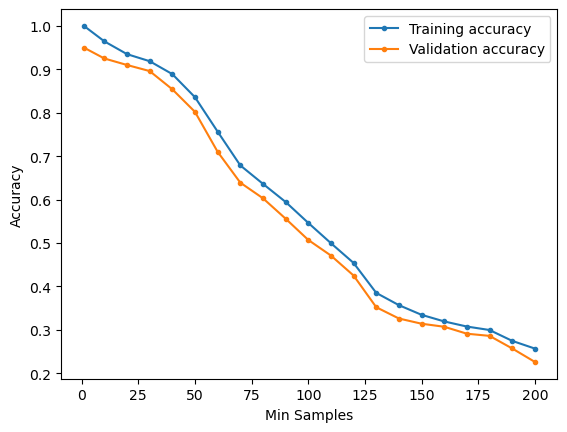

In [388]:
#plotting training and validation accuracies
plt.plot(minsamples, train_acc_all, marker='.', label="Training accuracy")
plt.plot(minsamples, val_acc_all, marker='.', label="Validation accuracy")
plt.xlabel('Min Samples')
plt.ylabel('Accuracy')
plt.legend()

**Using GridSearchCV to find best parameters for decision tree and random forest models**

In [389]:
X_train_TFIDF, X_test_TFIDF, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

model_dt= DecisionTreeClassifier(criterion= 'gini',random_state=42)
param_grid = {
    #'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50], 
    # 'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1] + list(range(10,51,10)),
    'max_features': [x for x in range(10,501,50)]
}

grid_search = GridSearchCV(estimator=model_dt, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_TFIDF, Y_train)
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_dt_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_dt_model.score(X_test_TFIDF, Y_test)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'max_depth': None, 'max_features': 310, 'min_samples_leaf': 1}
Test Accuracy: 0.805


In [390]:

model_rf= RandomForestClassifier(criterion= 'gini',random_state=42)
param_grid = {
    'n_estimators': [x for x in range(10,101,50)],
    #'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    # 'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1] + list(range(10,51,10))
}

grid_search = GridSearchCV(estimator=model_rf, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train_TFIDF, Y_train)
print("Best Parameters:", grid_search.best_params_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_rf_model.score(X_test_TFIDF, Y_test)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 60}
Test Accuracy: 0.975


**Evaluating the choosen Random Forest Classifier**

In [391]:
Y_pred = best_rf_model.predict(X_test_TFIDF)


accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy : ", accuracy)

precision = precision_score(Y_test, Y_pred, average='weighted')
print("Precision : ", precision)

recall = recall_score(Y_test, Y_pred, average='weighted')
print("Recall : ", recall)

f1 = f1_score(Y_test, Y_pred, average='weighted')
print("f1_score : ", f1)

conf_matrix = confusion_matrix(Y_test, Y_pred)
print("Confusion Matrix: \n",conf_matrix)

Accuracy :  0.975
Precision :  0.9749766081871344
Recall :  0.975
f1_score :  0.9748134327223866
Confusion Matrix: 
 [[43  0  0  0  1]
 [ 1 39  1  1  0]
 [ 0  0 35  0  0]
 [ 0  0  0 56  0]
 [ 0  1  0  0 22]]


**Predicting labels for the given test data**

In [392]:
test_data = pd.read_csv('news-test.csv')
X_test  = tfidf_main("news-test.csv", dictionary, True)

test_data['predictedLabel'] = best_rf_model.predict(X_test)

test_data[['ArticleId', 'predictedLabel']].to_csv("labels.csv", header=False, index=False)

100%|█████████████████████████████████████████| 736/736 [00:10<00:00, 69.35it/s]
